In [12]:
import damask
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [11]:
resultfile_path = 'reference_output/tension_hold_compress_material_meanfield_20materials_0.5ferrite_0.5martensite_20grains_voronoi_5x4x1/simulation_output.hdf5'

In [13]:
result = damask.Result(resultfile_path)
try:
    result.add_stress_Cauchy()
except ValueError:
    pass
try:
    result.add_equivalent_Mises('sigma')
except ValueError:
    pass
try:
    result.add_stress_second_Piola_Kirchhoff()
except ValueError:
    pass

try:
    result.add_strain()
except ValueError:
    pass

postprossecing_dir = Path(resultfile_path).stem
vti_path = list(Path(resultfile_path).parent.glob("*.vti"))[0]
grid = damask.GeomGrid.load(vti_path)
grid

cells:  5 × 4 × 1
size:   5e-05 × 4e-05 × 1e-05 m³
origin: 0.0   0.0   0.0 m
# materials: 20

In [14]:
for inc in result.get(['F','P']).values():
    print(inc.keys())
    break

dict_keys(['Ferrite', 'Martensite'])


# Example: Stress-strain curve for tensionX

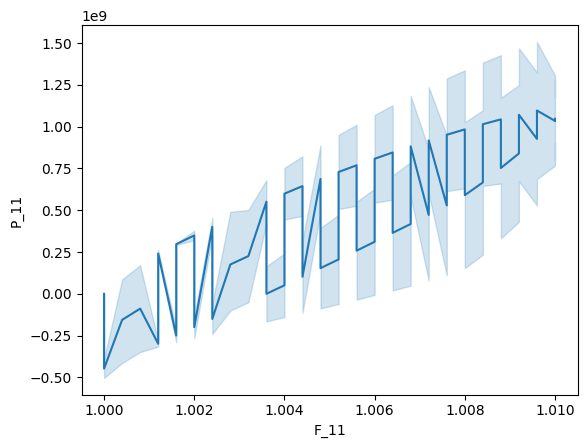

In [18]:
def plot_stress_strain_per_grain_meanfield(grains, grid, result):
    data = {g:pd.DataFrame() for g in grains}
    for volumefractions in result.get(['F','P']).values():
        for volumefraction, inc in volumefractions.items():
            P = inc['P']
            F = inc['F']
            for g in grains:
                points = grid.material.flatten(order='F')==g
                P_11 = P[points,0,0].flatten()
                F_11 = np.broadcast_to(np.average(F[:,0,0]),P_11.shape)
                x = pd.DataFrame({'F_11':F_11,'P_11':P_11})
                data[g] = pd.concat((data[g],x),ignore_index=True)
    for g in grains:
      plot = sns.lineplot(y='P_11',x='F_11',data=data[g])
    fig = plot.get_figure()

plot_stress_strain_per_grain_meanfield([0], grid, result)


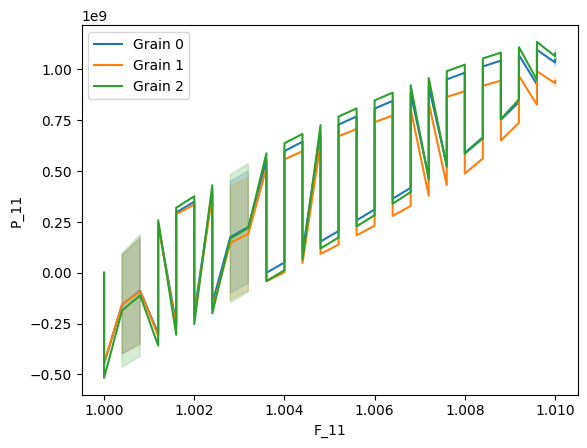

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_stress_strain_per_grain_meanfield(grains, grid, result):
    data = {g: pd.DataFrame() for g in grains}

    # Loop through increments in result and average across volumefractions
    for inc in result.get(['F', 'P']).values():
        avg_P, avg_F = {}, {}

        # Aggregate F and P across volumefractions
        for volumefraction, values in inc.items():
            P = values['P']
            F = values['F']

            for g in grains:
                points = grid.material.flatten(order='F') == g
                if g not in avg_P:
                    avg_P[g] = np.zeros(P[points, 0, 0].shape)
                    avg_F[g] = np.zeros(P[points, 0, 0].shape)

                avg_P[g] += P[points, 0, 0].flatten()
                avg_F[g] += np.broadcast_to(np.average(F[:, 0, 0]), avg_P[g].shape)

        # Compute the average over all volumefractions for each grain
        for g in grains:
            num_volumefractions = len(inc)
            avg_P[g] /= num_volumefractions
            avg_F[g] /= num_volumefractions

            # Add averaged values to the data DataFrame
            x = pd.DataFrame({'F_11': avg_F[g], 'P_11': avg_P[g]})
            data[g] = pd.concat((data[g], x), ignore_index=True)

    # Plot for each grain
    for g in grains:
        sns.lineplot(y='P_11', x='F_11', data=data[g], label=f'Grain {g}')

    # Show plot with legend
    plt.xlabel("F_11")
    plt.ylabel("P_11")
    plt.legend()
    plt.show()

# Example call
plot_stress_strain_per_grain_meanfield([0, 1, 2], grid, result)


# Example: Stress-Strain Density plot for each grain 

In [17]:
result = damask.Result(resultfile_path)
last_inc = result.view(increments=-1)
last_inc = result.view(homogenizations=False)
last_inc
df = pd.DataFrame({'F_11':last_inc.get('F')[:,0,0],
                   'P_11':last_inc.get('P')[:,0,0]})
# _ = df.plot.hexbin(x='F_11',y='P_11',gridsize=20,
#                    cmap=damask.Colormap.from_predefined('strain'))

TypeError: unhashable type: 'slice'

# Example: r-value calculation

In [1]:
result = damask.Result(resultfile_name)
result.add_strain('F_p','U')
result.add_equivalent_Mises('epsilon_U^0.0(F_p)')
epsilon_avg = np.array([np.average(eps,0) for eps in result.get('epsilon_U^0.0(F_p)').values()])
r = epsilon_avg[:,1,1]/epsilon_avg[:,2,2]
s = np.array([np.average(strain) for strain in result.get('epsilon_U^0.0(F_p)_vM').values()])
plt.plot(s[10:],r[10:])
plt.ylabel('r-value')
plt.xlabel('plastic vM strain')
plt.axis([0, 0.2, 0, 1])
plt.show()